# 1.0 Convolutional Neural Network for Regression

In this demo code, we will:

<ul>
<li>Create a synthetic dataset for regression based on the MNIST dataset.</li>
<li>Design a regression model based on a convolutional neural network.</li>
<li>Use Keras as the deep learning framework.</li>
<li>Dissect the regression model by visualizing the filter activations.</li>
</ul>

In [163]:
import pandas as pd
from sklearn.decomposition import PCA

#load Fashion MNIST dataset 
%matplotlib inline
import numpy as np
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

#normalize the images
x_train = np.expand_dims(x_train/255.0, axis=-1)
x_test = np.expand_dims(x_test/255.0, axis=-1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


In [164]:
#plot function for sample images

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

def plot_tile(samples):
    
    num_samples, x_dim, y_dim, _ = samples.shape
    axes = (np.round(np.sqrt(num_samples))).astype(int)
    fig = plt.figure(figsize=(axes, axes))
    gs = gridspec.GridSpec(axes, axes)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(sample, cmap=plt.get_cmap('viridis'), aspect='auto')

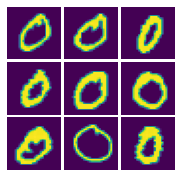

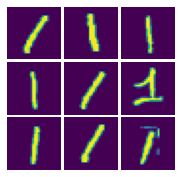

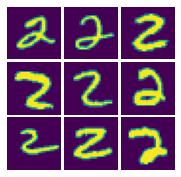

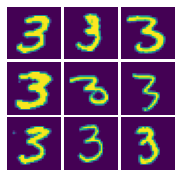

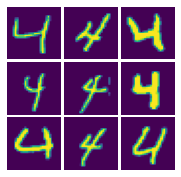

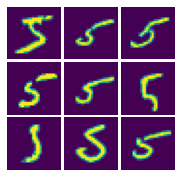

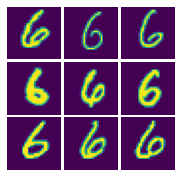

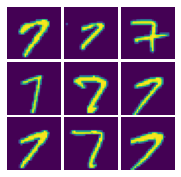

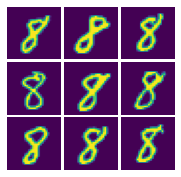

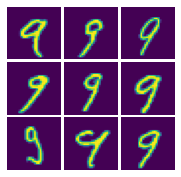

In [165]:
#visualize first 9 samples of input images based on class labels, within the training dataset

unique_labels, label_counts = np.unique(y_train, return_counts=True)

for label in unique_labels:
    x_train_perlabel = x_train[np.squeeze(y_train) == label]
    fig = plot_tile(x_train_perlabel[0:9, :, :])

In [166]:
#create (simulate) a synthetic "time series" data vector (y) for each of the input (x) such that y=Gx and G is linear

#G represents some abstract function (i.e. fluid flow simulator)
G = np.load('G.npy')

y_dim = G.shape[-1]
y_reg_train = np.zeros([y_train.shape[0], y_dim])
y_reg_test = np.zeros([y_test.shape[0], y_dim])

#simulate Y = GX
for i in range(y_train.shape[0]):
    y_reg_train[i:i+1, :] = np.reshape((x_train[i:i+1, :, :, 0]), [1, x_train.shape[1]*x_train.shape[2]])@G

for i in range(y_test.shape[0]):
    y_reg_test[i:i+1, :] = np.reshape((x_test[i:i+1, :, :, 0]), [1, x_test.shape[1]*x_test.shape[2]])@G

print(y_reg_train.shape)
print(y_reg_test.shape)

(60000, 128)
(10000, 128)


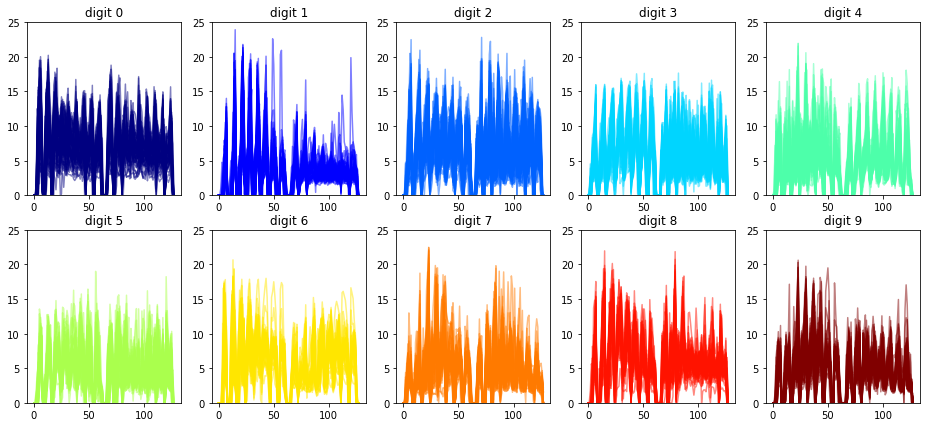

In [167]:
#visualize the generated signals (for training dataset) 

import matplotlib.cm as cm
from matplotlib.colors import Normalize

fig, ax = plt.subplots(1,1, figsize = (16, 7))

my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_train))

for j in range(10):
    plt.subplot(2, 5, j+1)
    for i in range(500):
        if (y_train[i] == j):
            plt.plot(y_reg_train[i, :], c=cs[i], alpha=0.5)
    plt.ylim([0, 25])
    plt.title('digit '+str(j))

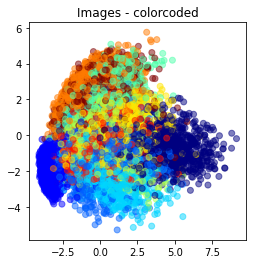

In [302]:
#visualize both x and y with PCA (for training dataset) 

#reduce images to two dimensions to visualize 
data_f = np.reshape(x_train, (-1, 28*28*1))

#pca on dataset
pca = PCA(n_components=16)
pca.fit(data_f)

#store results of PCA in a dataframe
result = pd.DataFrame(pca.transform(data_f), columns=['PCA%i' % i for i in range(16)])

#display some images in 2D
num_samples_disp = 10000

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(result['PCA0'][0:num_samples_disp], result['PCA1'][0:num_samples_disp], c=cs[y_train[0:num_samples_disp]], alpha=0.5)
ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
plt.title('Images - colorcoded')
plt.show()

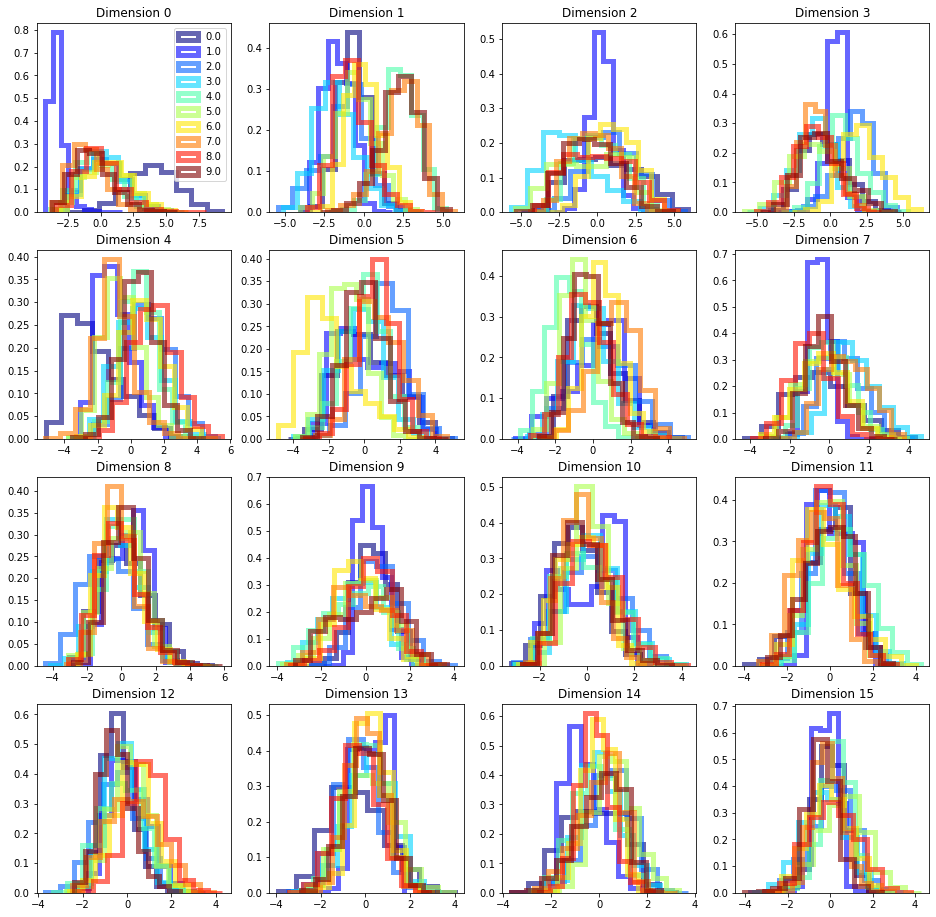

In [305]:
#plot the first 16 PCs of PCA for the middle layer, by digit label

result_np = result.to_numpy()

#color by label
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(np.linspace(0, 9, 10)))

plt.figure(figsize=[16, 16])
xax = np.linspace(0, 15, 16)

for j in range(result_np.shape[1]):
    plt.subplot(4, 4, j+1)
    result_np_dim = result_np[:, j]
    
    for i in range(10):
        result_np_dim_label = result_np_dim[y_train == i]
        plt.hist(result_np_dim_label, color=cs[i], density=True, histtype='step', linewidth=5, alpha=0.6)
    plt.title('Dimension '+str(j))
    if j == 0:
        plt.legend(np.linspace(0, 9, 10))

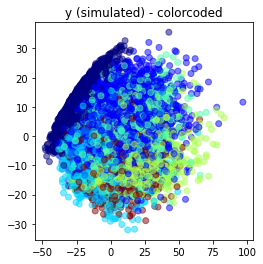

In [169]:
#visualize both x and y with PCA (for training dataset) 

#reduce simulated y to two dimensions to visualize 
data_f = y_reg_train

#pca on dataset
pca = PCA(n_components=2)
pca.fit(data_f)

#store results of PCA in a dataframe
result = pd.DataFrame(pca.transform(data_f), columns=['PCA%i' % i for i in range(2)])

#display some images in 2D
num_samples_disp = 10000

fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(result['PCA0'][0:num_samples_disp], result['PCA1'][0:num_samples_disp], c=cs[y_train[0:num_samples_disp]], alpha=0.5)
ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
plt.title('y (simulated) - colorcoded')
plt.show()

In [170]:
#define a regression model with Keras 

import keras
from keras.models import Model

from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from keras.layers import Input, LeakyReLU, Reshape
from keras import backend as K

from keras.optimizers import Adam
from IPython.display import clear_output
from keras.callbacks import History 

#function to view training and validation losses
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss", c = 'green')
        plt.plot(self.x, self.val_losses, label="val_loss", c = 'red')
        plt.legend()
        plt.show()

In [172]:
#define the convolutional neural network architecture

input_img = Input(shape=(x_train.shape[1], x_train.shape[1], 1)) 

_ = Conv2D(8, (3, 3), activation='linear', padding='same')(input_img)
_ = LeakyReLU(alpha=0.3)(_)
f1 = MaxPooling2D((2, 2), padding='same')(_)

_ = Conv2D(16, (4, 4), activation='linear', padding='same')(f1)
_ = LeakyReLU(alpha=0.3)(_)
f2 = MaxPooling2D((2, 2), padding='same')(_)

_ = Conv2D(32, (5, 5), activation='linear', padding='same')(f2)
_ = LeakyReLU(alpha=0.8)(_)
f3 = MaxPooling2D((2, 2), padding='same')(_)

_ = Reshape((16*32,))(f3)
_ = Dense(16)(_)
f4 = LeakyReLU(alpha=0.3)(_)

_ = Dense(32)(f4)
_ = LeakyReLU(alpha=0.3)(_)

_ = Dense(64)(_)
_ = LeakyReLU(alpha=0.3)(_)

out = Dense(128)(_)

In [173]:
#set loss function, optimizer and compile

regression = Model(input_img, out)
opt = keras.optimizers.Adam(lr=1e-4)
regression.compile(optimizer=opt, 
                   loss="mse", 
                   metrics=['mse'])

#get summary of architecture parameters and plot arch. diagram
regression.summary()
from keras.utils import plot_model
plot_model(regression, to_file='regression.png')

plot_losses = PlotLosses()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
leaky_re_lu_219 (LeakyReLU)  (None, 28, 28, 8)         0         
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 14, 14, 16)        2064      
_________________________________________________________________
leaky_re_lu_220 (LeakyReLU)  (None, 14, 14, 16)        0         
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 7, 7, 16)          0         
__________

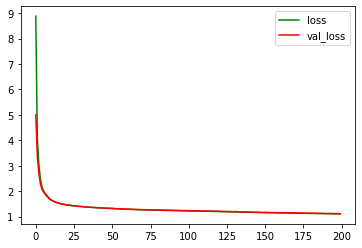

In [174]:
#train the neural network

regression.fit(x_train, y_reg_train,        
                epochs=200,
                batch_size=32,
                shuffle=True,
                validation_split=0.2,
                callbacks=[plot_losses])

In [176]:
#save and load the trained model

regression.save('regression.h5')

#from keras.models import load_model
#regression = load_model('regression.h5')

In [177]:
#get the predictions for the train dataset
y_reg_train_hat = regression.predict(x_train)

#get the predictions for the test dataset
y_reg_test_hat = regression.predict(x_test)

Text(0.5, 1.0, 'Train dataset')

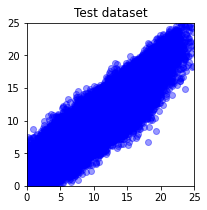

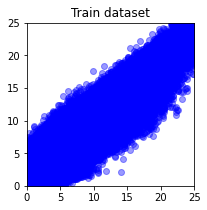

In [178]:
#check the prediction vs actual data
plt.figure(figsize=[3, 3])
plt.scatter(y_reg_test.flatten(), y_reg_test_hat.flatten(), alpha=0.4, c='blue')
plt.xlim([0, 25])
plt.ylim([0, 25])
plt.title('Test dataset')

plt.figure(figsize=[3, 3])
plt.scatter(y_reg_train.flatten(), y_reg_train_hat.flatten(), alpha=0.4, c='blue')
plt.xlim([0, 25])
plt.ylim([0, 25])
plt.title('Train dataset')

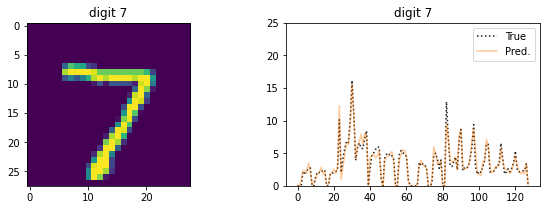

In [260]:
#functions to plot testing data and the prediction (vs actual data)

test_case = 0

#color by label
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(y_test))

plt.figure(figsize=[10, 3])
plt.subplot(1, 2, 1)
plt.imshow(x_test[test_case, :, :, 0])
plt.title('digit '+str(y_test[test_case]))

plt.subplot(1, 2, 2)
plt.plot(y_reg_test[test_case, :], ls=':', c='k', label='True', alpha=0.9)
plt.plot(y_reg_test_hat[test_case, :], c=cs[test_case], label='Pred.', alpha=0.4)
plt.ylim([0, 25])
plt.title('digit '+str(y_test[test_case]))
plt.legend()

In [261]:
#function to tile the third dimension

def collapse_channel(w):
    
    x_dim, y_dim, channel_dim = w.shape
    axes = (np.round(np.sqrt(channel_dim))).astype(int)
    w_merged = np.zeros([x_dim*axes, y_dim*axes])
    
    k = 0
    for i in range(axes):
        for j in range(axes):

            start_xidx = i*x_dim
            end_xidx = start_xidx + x_dim
            start_yidx = j*y_dim
            end_yidx = start_yidx + y_dim   

            w_merged[start_xidx:end_xidx, start_yidx:end_yidx] = w[:, :, k]
            k = k+1
            if k == channel_dim:
                break
    return w_merged

#function to get the trained kernel weights and visualize
def get_weights(model):
    for layer in model.layers:
        if 'conv2d' in layer.name:
            print(layer.name)
            w, b = layer.get_weights()
            print("Weights of layer {} {}".format(layer.name, w.shape))
            
            w_max, w_min = np.max(w), np.min(w)
            w = (w - w_min) / (w_max - w_min)
            
            plt.figure()
            for i in range(w.shape[-1]):
                axes = (np.round(np.sqrt(w.shape[-1]))).astype(int)
                ax = plt.subplot(axes, axes, i+1)
                
                #tile within each subplot
                w_i = collapse_channel(w[:, :, :, i])
                plt.imshow(w_i, cmap='jet')
                plt.xticks([])
                plt.yticks([])
                plt.axis('off')
                ax.set_aspect('equal')

conv2d_55
Weights of layer conv2d_55 (3, 3, 1, 8)
conv2d_56
Weights of layer conv2d_56 (4, 4, 8, 16)
conv2d_57
Weights of layer conv2d_57 (5, 5, 16, 32)


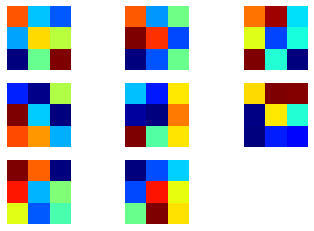

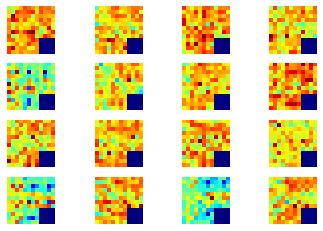

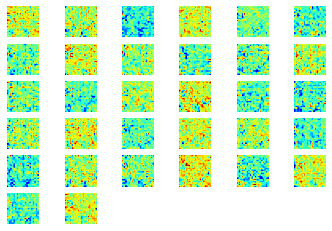

In [262]:
#get the weights for the convolutional layers

get_weights(regression)

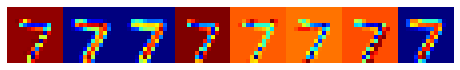

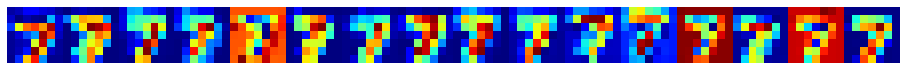

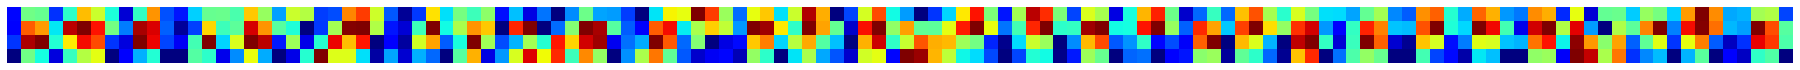

In [263]:
#visualize the activations for the convolutional layers (conv>nonlinear>pool)

test_case = 0

activations = [f1, f2, f3]
for activation in activations:
    act_classifier = Model(input_img, activation)
    act_out = act_classifier.predict(x_test[test_case:test_case+1])
    _, x_dim, y_dim, num_features = act_out.shape
    act_grid = np.zeros([x_dim, x_dim*num_features])
    
    for f_idx in range(num_features):
        feature = act_out[0, :, :, f_idx]
        feature = (feature - np.min(feature)) / (np.max(feature) - np.min(feature))
        act_grid[:, (f_idx*y_dim): (f_idx*y_dim)+y_dim] = feature
    
    plt.figure(figsize=[num_features, num_features*4])
    plt.imshow(act_grid, cmap='jet')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

In [268]:
#get the activations for the middle layer (first dense layer)

act_regression = Model(regression.layers[0].input, regression.layers[12].output)
act_out = act_regression.predict(x_test)

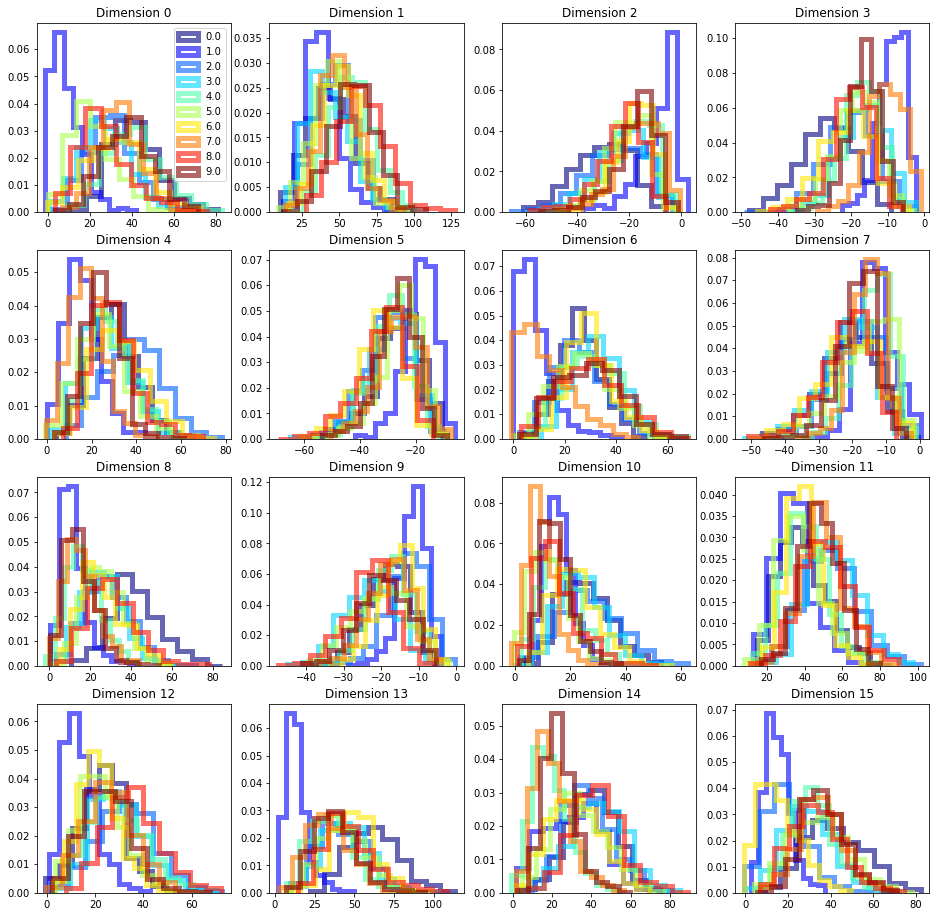

In [300]:
#plot the activations for the middle layer, by digit label

#color by label
my_cmap = cm.get_cmap('jet')
my_norm = Normalize(vmin=0, vmax=9)
cs = my_cmap(my_norm(np.linspace(0, 9, 10)))

plt.figure(figsize=[16, 16])
xax = np.linspace(0, 15, 16)

for j in range(act_out.shape[1]):
    plt.subplot(4, 4, j+1)
    act_out_dim = act_out[:, j]
    
    for i in range(10):
        act_out_dim_label = act_out_dim[y_test == i]
        plt.hist(act_out_dim_label, color=cs[i], density=True, histtype='step', linewidth=5, alpha=0.6)
    plt.title('Dimension '+str(j))
    if j == 0:
        plt.legend(np.linspace(0, 9, 10))